<a href="https://colab.research.google.com/github/efacundoargana/EPH_Properati_Analysis/blob/main/EPH_Properati_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis using income and house pricing data
Inspired by the work done by Pablo Orazi, found here: https://twitter.com/pablo_orazi/status/1427601914494177287


In [ ]:
# Import libraries
from urllib.request import urlopen
from io import BytesIO, StringIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
import gzip
import requests

### Read input information

We will read data from four different data sources:
* EPH, from INDEC
* Housing prices, from Properati
* Salary information, from INDEC
* Exchange rate information, from BCRA

In [ ]:
# Read EPH
url_zip = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_1_Trim_2021_txt.zip"

http_response = urlopen(url_zip)
zipfile = ZipFile(BytesIO(http_response.read()))

archivo_txt = zipfile.open("EPH_usu_1_Trim_2021_txt/usu_individual_T121.txt")

df = pd.read_csv(archivo_txt, sep=";")

In [ ]:
# Read properati information
url_prop = "https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz"
http_response = urlopen(url_prop)
zipfile = gzip.open(BytesIO(http_response.read()), 'rb')
file_content=zipfile.read()

# Write txt with Properati data as bytes cannot be read
s=str(file_content,'utf-8')
file = open("prop_data.txt","w")
file.write(s)

# Read properati data
df_prop = pd.read_csv('prop_data.txt')

In [ ]:
# Read Salary information
url_salary = "https://www.indec.gob.ar/ftp/cuadros/sociedad/variaciones_salarios_08_21.xls"

cols = ['Year', 'Month', 'Private MoM Variation', 'Private Index',
        'Public MoM Variation', 'Public Index', 'Registered MoM Variation',
        'Registered Index', 'NonRegistered MoM Variation',
        'NonRegistered Index', 'Total MoM Variation', 'Total Index']
df_salary = pd.read_excel(url_salary, header=7)
df_salary.columns = cols
df_salary['Year'] = df_salary['Year'].fillna(method='ffill')

In [ ]:
# Read dollar Exchange Rate information
url_dollar = "http://www.bcra.gob.ar/Pdfs/PublicacionesEstadisticas/com3500.xls"
df_dollar = pd.read_excel(url_dollar, header=3)
df_dollar['Fecha'] = pd.to_datetime(df_dollar['Fecha'])

### Pre-Process Data

For the pre-processing we will
* Scale salaries to reflect values in June-2020 ARS
* Filter data, both in the EPH and in the Properati Dataset
* Convert housing prices to ARS

Documentation on the EPH can be found in the following link: https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_diseno_reg_t414.pdf

In [ ]:
# Calculate salary index comparing June-2021 with March-2021
salary_index_june = df_salary[(df_salary['Year'] == '2021* ') &
                              (df_salary['Month'] == 'Junio')
                              ].reset_index(
                                  drop=True)
salary_index_june = salary_index_june['Total Index'][0]

salary_index_march = df_salary[(df_salary['Year'] == '2021* ') &
                              (df_salary['Month'] == 'Marzo')
                              ].reset_index(
                                  drop=True)
salary_index_march = salary_index_march['Total Index'][0]
salary_ratio = salary_index_june / salary_index_march

In [ ]:
# Scale Salary column to June-2021 ARS
df['REAL_INCOME'] = df['P47T'] * salary_ratio

In [ ]:
"""
Filter EPH information

The filters we will apply will be
* Complete University Studies (NIVEL_ED = 6)
* Worker (CAT_OCUP = 3)
* Positive income (REAL_INCOME > 0)
"""
df.query('NIVEL_ED == 6 and CAT_OCUP == 3 and REAL_INCOME > 0', inplace=True)

In [ ]:
"""
Filter properati information
* Filter old ads (end_date < today)
* Just selling ands-no renting (operation_type = 'Venta')
* Keep Housing ads (property_type in ('Casa', 'Departamento', 'PH'))
* Keep ads in USD (currency = 'USD')
* Keep ads with a price (price > 0)
"""
df_prop.query("end_date < '2021-08-18' and operation_type == 'Venta' and currency == 'USD' and price > 0 and surface_total > 0 and l1 == 'Argentina'", inplace=True)
df_prop = df_prop[df_prop['property_type'].isin(['Casa', 'Departamento', 'PH'])]

In [ ]:
# Transform prices to ARS
fx_date = df_dollar[df_dollar['Fecha'].astype(str) == '2021-06-30'].reset_index(drop=True)
fx = fx_date['Tipo de Cambio de Referencia - en Pesos - por Dólar'][0]

# We multiply the values given existing taxes
fx = fx*1.3*1.35

In [ ]:
df_prop['price_ars'] = df_prop['price'] * fx
df_prop['price_m2'] = df_prop['price'] / df_prop['surface_total']
df_prop['price_60_m2'] = df_prop['price_m2'] * 60
df_prop['price_60_m2_ars'] = df_prop['price_m2'] * 60 * fx

### Analyze Data

In this analysis we will
* Calculate income distribution
* Calculate median and 75th percentile of income distribution by age group and region
* Calculate number of years necessary to buy a 60m2 apartment by region and age group

#### Calculate income distribution

In [ ]:
def weighted_quantile(values, quantiles, sample_weight=None,
                      values_sorted=False, old_style=False):
  # Source: https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [ ]:
quantiles = weighted_quantile(values=df['REAL_INCOME'], quantiles=[0.25, 0.5, 0.75], sample_weight=df['PONDERA'])
quantiles

array([43428.44454313, 65142.6668147 , 97714.00022205])

Primer cuartil de los ingresos:  43428.44
Mediana de los ingresos:  65142.67
Tercer cuartil de los ingresos:  97714.0


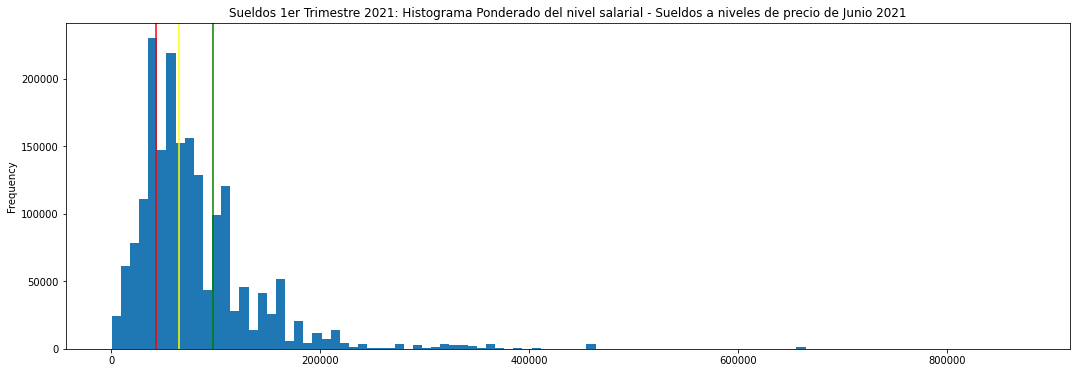

In [ ]:
# Plot of income distribution
ax = df['REAL_INCOME'].plot(kind="hist", weights=df['PONDERA'], bins=100, figsize=(18, 6))
df.sort_values('REAL_INCOME', inplace=True)
ax.set_title("Sueldos 1er Trimestre 2021: Histograma Ponderado del nivel salarial - Sueldos a niveles de precio de Junio 2021")

median = quantiles[1]
first_q = quantiles[0]
third_q = quantiles[2]
print("Primer cuartil de los ingresos: ", round(first_q, 2))
print("Mediana de los ingresos: ", round(median, 2))
print("Tercer cuartil de los ingresos: ", round(third_q, 2))
ax.axvline(median, color="yellow");
ax.axvline(first_q, color="red");
ax.axvline(third_q, color="green");

#### Calculate median and 75th percentile of income distribution by age group and region

In [ ]:
# Create an age group column
df['age_first_digit'] = np.floor(df['CH06'] / 10)
df['age_first_digit'] = df['age_first_digit'].astype(int)
df['age_group'] = df['age_first_digit'].astype(str) + "0-" + df['age_first_digit'].astype(str) + "9"

In [ ]:
# Create a dictionary in which we'll have region information
median_by_region = {
    "Gran Buenos Aires": {'Code': 1, 'Medians': [], 'Third Quartiles': []},
    "NOA": {'Code': 40, 'Medians': [], 'Third Quartiles': []},
    "NEA": {'Code': 41, 'Medians': [], 'Third Quartiles': []},
    "Cuyo": {'Code': 42, 'Medians': [], 'Third Quartiles': []},
    "Pampeana": {'Code': 43, 'Medians': [], 'Third Quartiles': []},
    "Patagónica": {'Code': 44, 'Medians': [], 'Third Quartiles': []},
}
age_groups = ['20-29', '30-39', '40-49', '50-59']

# Calculate median by region and age group
for region in median_by_region:
  for age_group in age_groups:
    df_filt = df[(df['REGION'] == median_by_region[region]['Code']) & (df['age_group'] == age_group)]
    quantiles = weighted_quantile(values=df_filt['REAL_INCOME'], quantiles=[0.5, 0.75], sample_weight=df_filt['PONDERA'])
    median_by_region[region]['Medians'].append(round(quantiles[0], 2))
    median_by_region[region]['Third Quartiles'].append(round(quantiles[1], 2))

In [ ]:
# Create results of medians
df_medians = pd.DataFrame(data={'Edad': age_groups})

for region in median_by_region:
  df_medians[region] = median_by_region[region]['Medians']

In [ ]:
print("Mediana del sueldo mensual por Edad y Región - EPH 1er Trimestre 2021 - Datos con precios de Junio 2021")
df_medians.style.background_gradient(axis=None)

Mediana del sueldo mensual por Edad y Región - EPH 1er Trimestre 2021 - Datos con precios de Junio 2021


,Edad,Gran Buenos Aires,NOA,NEA,Cuyo,Pampeana,Patagónica
0,20-29,56069.330000,34878.480000,37999.890000,43428.440000,39955.320000,58820.000000
1,30-39,57542.690000,47771.290000,51571.280000,48857.000000,58628.400000,70571.220000
2,40-49,74914.070000,54285.560000,57650.120000,54506.780000,65142.670000,91367.210000
3,50-59,86856.890000,65142.670000,59714.110000,80340.910000,75999.780000,92285.440000


In [ ]:
# Create results of medians
df_3q = pd.DataFrame(data={'Edad': age_groups})

for region in median_by_region:
  df_3q[region] = median_by_region[region]['Third Quartiles']

In [ ]:
print("Tercer cuartil del sueldo mensual por Edad y Región - EPH 1er Trimestre 2021 - Datos con precios de Junio 2021")
df_3q.style.background_gradient(axis=None)

Tercer cuartil del sueldo mensual por Edad y Región - EPH 1er Trimestre 2021 - Datos con precios de Junio 2021


,Edad,Gran Buenos Aires,NOA,NEA,Cuyo,Pampeana,Patagónica
0,20-29,93577.740000,48857.000000,48857.000000,70846.550000,56456.980000,89396.350000
1,30-39,106400.150000,75999.780000,69293.480000,73641.030000,81428.330000,108571.110000
2,40-49,98512.690000,81428.330000,75999.780000,83352.400000,86856.890000,121873.280000
3,50-59,141142.440000,88086.800000,86488.800000,103296.350000,108571.110000,135118.070000


#### Calculate number of years necessary to buy a 60m2 apartment by region and age group

In [ ]:
# Calculate histogram of the value of a 60m2 apartment


Primer cuartil de los precios:  65454.55
Mediana de los precios:  103493.45
Tercer cuartil de los precios:  147056.6


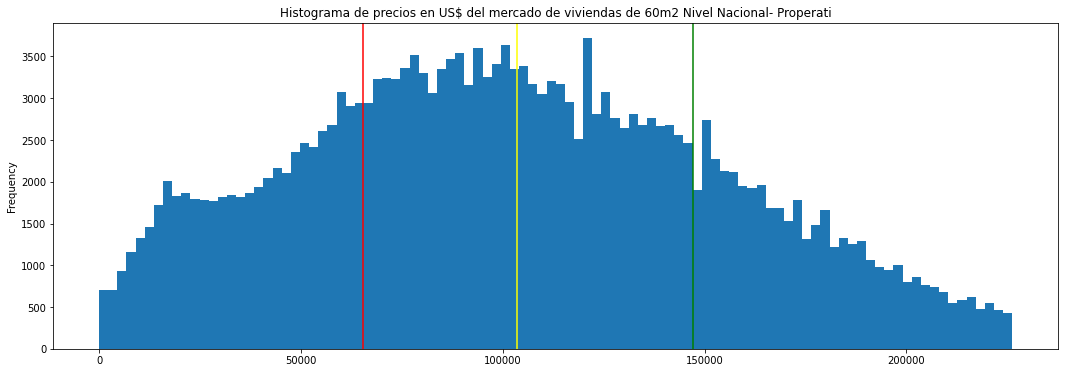

In [ ]:
# Plot of income distribution

# Filter until the 95th percentile because of outliers
ax = df_prop[df_prop['price_60_m2'] < np.nanpercentile(df_prop['price_60_m2'], 95)]['price_60_m2'].plot(kind="hist", bins=100, figsize=(18, 6))
ax.set_title("Histograma de precios en US$ del mercado de viviendas de 60m2 Nivel Nacional- Properati")

median = np.median(df_prop['price_60_m2'])
first_q = np.nanpercentile(df_prop['price_60_m2'], 25)
third_q = np.nanpercentile(df_prop['price_60_m2'], 75)
print("Primer cuartil de los precios: ", round(first_q, 2))
print("Mediana de los precios: ", round(median, 2))
print("Tercer cuartil de los precios: ", round(third_q, 2))
ax.axvline(median, color="yellow");
ax.axvline(first_q, color="red");
ax.axvline(third_q, color="green");

In [ ]:
# Create a dataframe that will relate regions in the EPH to the L2 in the Properati Table
# This was done to our best understanding, using the information in the EPH documentation
regions_dict = {
    'Capital Federal': 1, 'Santa Fe' : 43, 'Bs.As. G.B.A. Zona Norte' : 1,
       'Bs.As. G.B.A. Zona Oeste' : 1, 'Bs.As. G.B.A. Zona Sur': 1, 'Mendoza': 42,
       'Buenos Aires Interior': 43, 'Misiones': 41,
       'Buenos Aires Costa Atlántica': 43, 'Córdoba': 43, 'Entre Ríos': 43,
       'Río Negro': 44, 'Neuquén': 44, 'Tucumán': 40, 'Chubut': 44, 'San Luis': 42,
       'Corrientes': 41, 'Salta': 40, 'San Juan': 42, 'Jujuy': 40, 'La Pampa': 43, 'Chaco': 41,
       'Santa Cruz': 44, 'La Rioja': 40, 'Tierra Del Fuego': 44,
       'Santiago Del Estero': 40, 'Catamarca': 40, 'Formosa': 41
}
df_regions = pd.DataFrame(data={
    'l2': list(regions_dict.keys()),
    'REGION': [regions_dict[region] for region in regions_dict.keys()]
})
df_prop = pd.merge(df_prop, df_regions, how='left', on='l2')

In [ ]:
# Calculate the median of the price of a 60m2 apartment by region
price_median_by_region = {}

for region in df['REGION'].unique():
  df_prop_filt = df_prop[df_prop['REGION'] == region]
  price_median_by_region[region] = np.median(df_prop_filt['price_60_m2_ars'])

In [ ]:
# Create a dictionary in which we'll have region information
months_by_region = {
    "Gran Buenos Aires": {'Code': 1, 'Months of Savings': []},
    "NOA": {'Code': 40, 'Months of Savings': []},
    "NEA": {'Code': 41, 'Months of Savings': []},
    "Cuyo": {'Code': 42, 'Months of Savings': []},
    "Pampeana": {'Code': 43, 'Months of Savings': []},
    "Patagónica": {'Code': 44, 'Months of Savings': []},
}
age_groups = ['20-29', '30-39', '40-49', '50-59']

# Calculate months necessary to buy 60m2 apartment by region and age group,
# assuming you are saving 50% of your income
for region in median_by_region:
  for age_group in age_groups:
    df_filt = df[(df['REGION'] == median_by_region[region]['Code']) & (df['age_group'] == age_group)]
    quantiles = weighted_quantile(values=df_filt['REAL_INCOME'], quantiles=[0.5, 0.75], sample_weight=df_filt['PONDERA'])
    income_median = quantiles[0]
    monthly_savings = income_median
    price = price_median_by_region[median_by_region[region]['Code']]
    months_by_region[region]['Months of Savings'].append(price/monthly_savings)

In [ ]:
# Create results of medians
df_months = pd.DataFrame(data={'Edad': age_groups})

for region in months_by_region:
  df_months[region] = months_by_region[region]['Months of Savings']

In [ ]:
print("Meses necesarios de ahorro para comprar un departamento de 60m2 por edad y región - Ahorro del 50% del sueldo de dos personas")
df_months.style.background_gradient(axis=None)

Meses necesarios de ahorro para comprar un departamento de 60m2 por edad y región - Ahorro del 50% del sueldo de dos personas


,Edad,Gran Buenos Aires,NOA,NEA,Cuyo,Pampeana,Patagónica
0,20-29,344.146094,223.978121,331.580624,136.362532,301.508152,232.952333
1,30-39,335.334367,163.529535,244.322565,121.211139,205.478146,194.162080
2,40-49,257.575673,143.905991,218.560299,108.647258,184.930332,149.969068
3,50-59,222.159018,119.921659,211.005851,73.711046,158.511713,148.476885


In [ ]:
df_years = df_months.copy()
for region in months_by_region:
  df_years[region] = round(df_years[region]/12, 2)

In [ ]:
print("Años necesarios de ahorro para comprar un departamento de 60m2 por edad y región - Ahorro del 50% del sueldo de dos personas")
df_years.style.background_gradient(axis=None)

Años necesarios de ahorro para comprar un departamento de 60m2 por edad y región - Ahorro del 50% del sueldo de dos personas


,Edad,Gran Buenos Aires,NOA,NEA,Cuyo,Pampeana,Patagónica
0,20-29,28.680000,18.660000,27.630000,11.360000,25.130000,19.410000
1,30-39,27.940000,13.630000,20.360000,10.100000,17.120000,16.180000
2,40-49,21.460000,11.990000,18.210000,9.050000,15.410000,12.500000
3,50-59,18.510000,9.990000,17.580000,6.140000,13.210000,12.370000
